## Ejercicios con Python Tarea Clase 20
### Pablo Ángel Mendoza Aguirre

Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out. 
**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price y una barrera adecuada.

In [1]:
#importar los paquetes que se van a usar
import datetime
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import pandas_datareader.data as web
import scipy.cluster.hierarchy as hac
from datetime import datetime, timedelta
from sklearn.neighbors import KernelDensity
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_historical_closes(tickers, start_date=None, end_date=None, freq=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Frecuencia de muestreo por defecto (freq='d')
    # Importamos paquetes necesarios
    import pandas as pd
    pd.core.common.is_list_like = pd.api.types.is_list_like
    import pandas_datareader.data as web  
    # Creamos DataFrame vacío de precios, con el índice de las fechas
    closes = pd.DataFrame(columns = tickers, index=web.YahooDailyReader(symbols=tickers[0], start=start_date, end=end_date, interval=freq).read().index)
    # Agregamos cada uno de los precios con YahooDailyReader
    for ticker in tickers:
        df = web.YahooDailyReader(symbols=ticker, start=start_date, end=end_date, interval=freq).read()
        closes[ticker]=df['Adj Close']
    closes.index_name = 'Date'
    closes = closes.sort_index()
    return closes
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

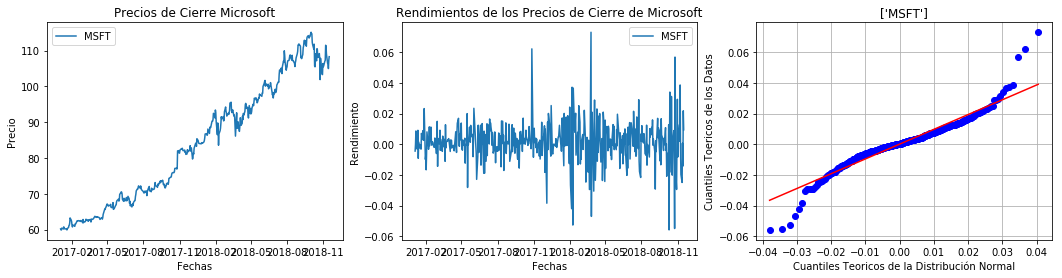

In [3]:
ticker1 = ['MSFT']
start_date = '2017-01-01'
date_fin = '2018-11-15'
closes_ma = get_historical_closes(ticker1, start_date,end_date=date_fin,freq='d')
ret_ma = calc_daily_ret(closes_ma)
miu_m=st.norm.fit(ret_ma)[0]
sig_m=st.norm.fit(ret_ma)[1]
plt.figure(figsize = (18,4))
plt.subplot(131)
plt.plot(closes_ma)
plt.title('Precios de Cierre Microsoft')
plt.xlabel('Fechas')
plt.ylabel('Precio')
plt.legend(ticker1)
plt.subplot(132)
plt.plot(ret_ma)
plt.title('Rendimientos de los Precios de Cierre de Microsoft')
plt.xlabel('Fechas')
plt.ylabel('Rendimiento')
plt.legend(ticker1)
ax1 = plt.subplot(133)
Norm_m = st.probplot(ret_ma['MSFT'],sparams=(miu_m,sig_m), dist=st.norm, fit = True, plot=plt)
plt.grid()
plt.xlabel('Cuantiles Teoricos de la Distribución Normal')
plt.ylabel('Cuantiles Toericos de los Datos')
plt.title(ticker1)
plt.show()

## Valuación de Opciones Europeas de Microsoft

### CALL EUROPEO
Suponiendo Rendimientos normales

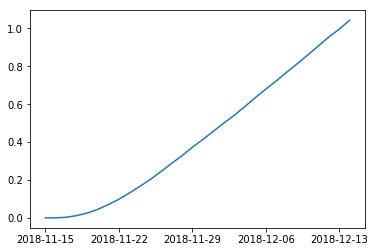

Prima de la Opción Calculada
Prima    1.043
Name: 2018-12-14 00:00:00, dtype: float64
Intervalo de Confianza de 90%
(1.0019375096910965, 1.0841932352545813)
(1.0019378906976348, 1.084192854248043)


In [4]:
mu = ret_ma.mean()[0]
sigma = ret_ma.std()[0]
r = 0.0273/360 # Tasa diaria, r = 0.0260/360, fecha del 11 de Noviembre de 2018
K= 115  # strike price
ndays = 30
nscen = 100000
dates = pd.date_range('2018-11-15', periods = ndays)
S0 = closes_ma.iloc[-1,0]  # Condición inicial del precio a simula
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros([ndays,nscen])).T.mean()}, index=dates)
plt.plot(call)
plt.show()
print('Prima de la Opción Calculada')
C_norm = call.iloc[-1]
print(call.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

Con el método de histograma

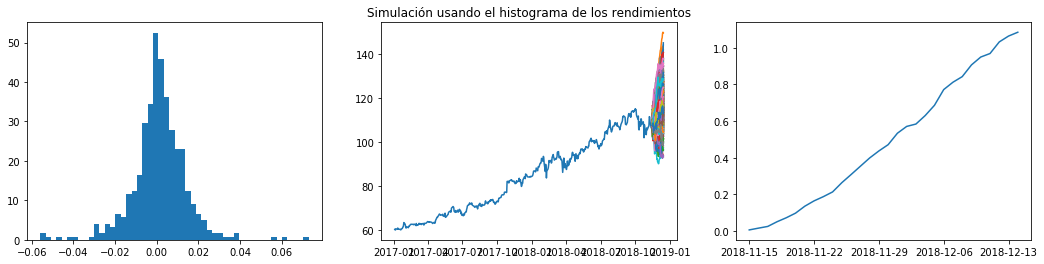

Prima de la Opción Calculada
Prima    1.085
Name: 2018-12-14 00:00:00, dtype: float64
Intervalo de Confianza de 90%
(1.0018997170356925, 1.0842310279099854)
(1.0019378906976348, 1.084192854248043)


In [5]:
nscen = 1000
plt.figure(figsize = (18,4))
plt.subplot(131)
ren = calc_daily_ret(closes_ma) # rendimientos 
y,x,des = plt.hist(ren['MSFT'],bins=50,density=True,label='Histograma rendimientos')
mu_fit,sd_fit = st.norm.fit(ren) # Se ajustan los parámetros de una normal# Valores máximo y mínimo de los rendiemientos a generar
plt.subplot(132)
ren_max = max(x)
ren_min = min(x)# Vector de rendimientos generados
ren_gen = np.arange(ren_min,ren_max,0.001)
prob = y/np.sum(y)
values = x[1:]
ret = np.random.choice(values, ndays*nscen, p=prob)
dates = pd.date_range('2018-11-15',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_ma.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
plt.plot(pd.concat([closes_ma,sim_closes_hist]))
plt.title('Simulación usando el histograma de los rendimientos')
plt.subplot(133)
freq, values = np.histogram(ret_ma+r-mu, bins=2000)
prob = freq/np.sum(freq)
ret=np.random.choice(values[1:],ndays*nscen,p=prob)
dates=pd.date_range('2018-11-15',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_ma.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
call_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
plt.plot(call_hist)
plt.show()
print('Prima de la Opción Calculada')
c_hist = call_hist.iloc[-1]
print(call_hist.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

### KO CALL EUROPEO (Down & Out) 
Suponiendo Rendimientos normales

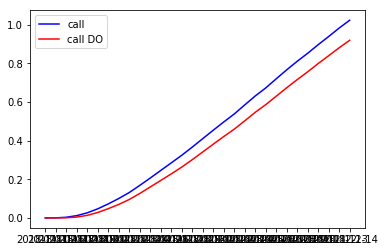

Prima de la Opción Calculada Call DO
Prima_do    0.92
Name: 2018-12-14, dtype: float64
Intervalo de Confianza de 90%
(0.8787675622555541, 0.9602842401380044)
(0.8787679398388414, 0.9602838625547171)


In [6]:
#spot en 108.29
mu = ret_ma.mean()[0]
sigma = ret_ma.std()[0]
r = 0.0273/360 # Tasa diaria, r = 0.0260/360, fecha del 11 de Noviembre de 2018
K= 115  # strike price
B = 110  # precio de barrera
ndays = 30
nscen = 100000
dates = pd.date_range('2018-11-15', periods = ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (closes_ma.iloc[-1][0])*np.exp(sim_ret.cumsum())
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes<barrier).cumsum()>0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
call = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes-strike,np.zeros((ndays,nscen))).T.mean()},index=dates)
calldo = pd.DataFrame({'Prima_do':np.exp(-r*ndays)*(I*np.fmax(sim_closes-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)
plt.plot(call, c = 'b')
plt.plot(calldo,c = 'r')
plt.legend(['call','call DO'])
plt.show()
print('Prima de la Opción Calculada Call DO')
CDO_norm = calldo.iloc[-1]
print(calldo.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = calldo.iloc[-1].Prima_do
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

Con el método de histograma

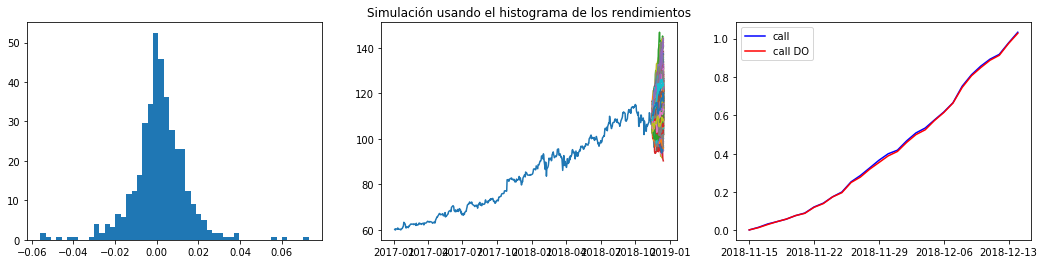

Prima de la Opción Calculada
Prima_do    1.028
Name: 2018-12-14 00:00:00, dtype: float64
Intervalo de Confianza de 90%
(0.9867487937441458, 1.068340377821777)
(0.9867866244250236, 1.0683025471408993)


In [7]:
nscen = 1000
plt.figure(figsize = (18,4))
plt.subplot(131)
ren = calc_daily_ret(closes_ma) # rendimientos 
y,x,des = plt.hist(ren['MSFT'],bins=50,density=True,label='Histograma rendimientos')
mu_fit,sd_fit = st.norm.fit(ren) # Se ajustan los parámetros de una normal# Valores máximo y mínimo de los rendiemientos a generar
plt.subplot(132)
ren_max = max(x)
ren_min = min(x)# Vector de rendimientos generados
ren_gen = np.arange(ren_min,ren_max,0.001)
prob = y/np.sum(y)
values = x[1:]
ret = np.random.choice(values, ndays*nscen, p=prob)
dates = pd.date_range('2018-11-15',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_ma.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
plt.plot(pd.concat([closes_ma,sim_closes_hist]))
plt.title('Simulación usando el histograma de los rendimientos')
plt.subplot(133)
freq, values = np.histogram(ret_ma+r-mu, bins=2000)
prob = freq/np.sum(freq)
ret=np.random.choice(values[1:],ndays*nscen,p=prob)
dates=pd.date_range('2018-11-15',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_ma.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
call_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
call_hist_do = pd.DataFrame({'Prima_do':np.exp(-r*ndays)*(I*np.fmax(sim_closes_hist-strike,np.zeros((ndays,nscen)))).T.mean()},index=dates)
plt.plot(call_hist, c = 'b')
plt.plot(call_hist_do,c = 'r')
plt.legend(['call','call DO'])
plt.show()
print('Prima de la Opción Calculada')
c_hist_do = call_hist_do.iloc[-1]
print(call_hist_do.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call_hist_do.iloc[-1].Prima_do
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

### PUT EUROPEO
Suponiendo Rendimientos normales

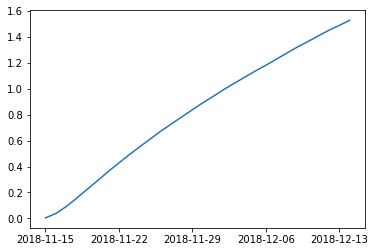

Prima de la Opción Calculada
Prima    1.526
Name: 2018-12-14 00:00:00, dtype: float64
Intervalo de Confianza de 90%
(1.485379355928069, 1.5671812009406383)
(1.4853797348322435, 1.5671808220364636)


In [8]:
mu = ret_ma.mean()[0]
sigma = ret_ma.std()[0]
r = 0.0273/360 # Tasa diaria, r = 0.0260/360, fecha del 11 de Noviembre de 2018
K= 105  # strike price
ndays = 30
nscen = 100000
dates = pd.date_range('2018-11-15', periods = ndays)
S0 = closes_ma.iloc[-1,0]  # Condición inicial del precio a simula
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
strike = pd.DataFrame(K*np.ones([ndays,nscen]), index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros([ndays,nscen])).T.mean()}, index=dates)
plt.plot(put)
plt.show()
print('Prima de la Opción Calculada')
P_norm = put.iloc[-1]
print(put.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

Con el método de histograma

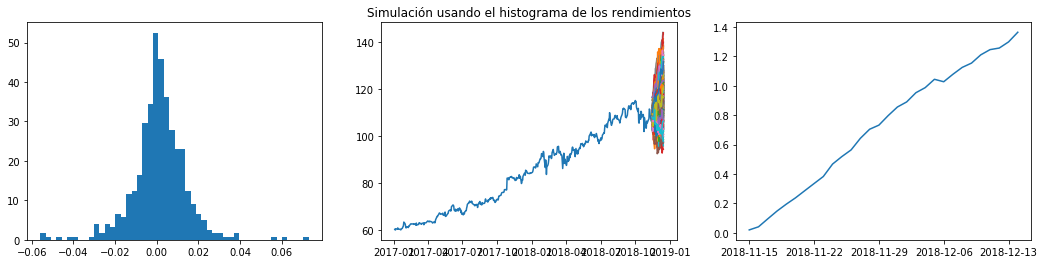

Prima de la Opción Calculada
Prima    1.363
Name: 2018-12-14 00:00:00, dtype: float64
Intervalo de Confianza de 90%
(1.4853417718095314, 1.567218785059176)
(1.4853797348322435, 1.5671808220364636)


In [9]:
nscen = 1000
plt.figure(figsize = (18,4))
plt.subplot(131)
ren = calc_daily_ret(closes_ma) # rendimientos 
y,x,des = plt.hist(ren['MSFT'],bins=50,density=True,label='Histograma rendimientos')
mu_fit,sd_fit = st.norm.fit(ren) # Se ajustan los parámetros de una normal# Valores máximo y mínimo de los rendiemientos a generar
plt.subplot(132)
ren_max = max(x)
ren_min = min(x)# Vector de rendimientos generados
ren_gen = np.arange(ren_min,ren_max,0.001)
prob = y/np.sum(y)
values = x[1:]
ret = np.random.choice(values, ndays*nscen, p=prob)
dates = pd.date_range('2018-11-15',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_ma.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
plt.plot(pd.concat([closes_ma,sim_closes_hist]))
plt.title('Simulación usando el histograma de los rendimientos')
plt.subplot(133)
freq, values = np.histogram(ret_ma+r-mu, bins=2000)
prob = freq/np.sum(freq)
ret=np.random.choice(values[1:],ndays*nscen,p=prob)
dates=pd.date_range('2018-11-15',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_ma.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
put_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
plt.plot(put_hist)
plt.show()
print('Prima de la Opción Calculada')
P_hist = put_hist.iloc[-1]
print(put_hist.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

### KO PUT EUROPEO (Up & Out) 
Suponiendo Rendimientos normales

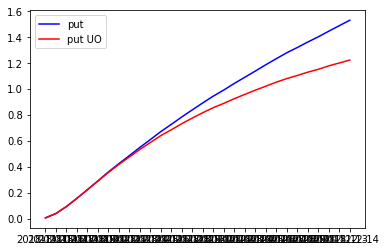

Prima de la Opción Calculada Put UO
Prima_uo    1.225
Name: 2018-12-14, dtype: float64
Intervalo de Confianza de 90%
(1.1838813076067531, 1.2657084961739808)
(1.1838816866283184, 1.2657081171524156)


In [10]:
#spot en 108.29
mu = ret_ma.mean()[0]
sigma = ret_ma.std()[0]
r = 0.0273/360 # Tasa diaria, r = 0.0260/360, fecha del 11 de Noviembre de 2018
K= 105  # strike price
B = 111  # precio de barrera
ndays = 30
nscen = 100000
dates = pd.date_range('2018-11-15', periods = ndays).astype('str')
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = (closes_ma.iloc[-1][0])*np.exp(sim_ret.cumsum())
barrier = pd.DataFrame(B*np.ones((ndays, nscen)),index=dates)
I = (sim_closes>barrier).cumsum()>0
strike = pd.DataFrame(K*np.ones((ndays, nscen)),index=dates)
put = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes,np.zeros((ndays,nscen))).T.mean()},index=dates)
putuo = pd.DataFrame({'Prima_uo':np.exp(-r*ndays)*(-I*np.fmax(strike-sim_closes,np.zeros((ndays,nscen)))).T.mean()},index=dates)
plt.plot(put, c = 'b')
plt.plot(putuo,c = 'r')
plt.legend(['put','put UO'])
plt.show()
print('Prima de la Opción Calculada Put UO')
PUO_norm = putuo.iloc[-1]
print(putuo.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = putuo.iloc[-1].Prima_uo
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

Con el método de histograma

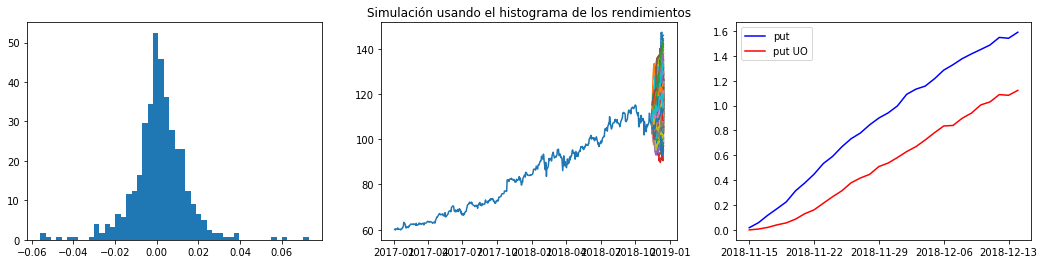

Prima de la Opción Calculada
Prima_uo    1.123
Name: 2018-12-14 00:00:00, dtype: float64
Intervalo de Confianza de 90%
(1.0819245667327864, 1.1638269468254436)
(1.0819625415170664, 1.1637889720411636)


In [11]:
nscen = 1000
plt.figure(figsize = (18,4))
plt.subplot(131)
ren = calc_daily_ret(closes_ma) # rendimientos 
y,x,des = plt.hist(ren['MSFT'],bins=50,density=True,label='Histograma rendimientos')
mu_fit,sd_fit = st.norm.fit(ren) # Se ajustan los parámetros de una normal# Valores máximo y mínimo de los rendiemientos a generar
plt.subplot(132)
ren_max = max(x)
ren_min = min(x)# Vector de rendimientos generados
ren_gen = np.arange(ren_min,ren_max,0.001)
prob = y/np.sum(y)
values = x[1:]
ret = np.random.choice(values, ndays*nscen, p=prob)
dates = pd.date_range('2018-11-15',periods=ndays)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_ma.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
plt.plot(pd.concat([closes_ma,sim_closes_hist]))
plt.title('Simulación usando el histograma de los rendimientos')
plt.subplot(133)
freq, values = np.histogram(ret_ma+r-mu, bins=2000)
prob = freq/np.sum(freq)
ret=np.random.choice(values[1:],ndays*nscen,p=prob)
sim_ret_hist = pd.DataFrame(ret.reshape((ndays,nscen)),index=dates)
sim_closes_hist = (closes_ma.iloc[-1,0])*np.exp(sim_ret_hist.cumsum())
strike = pd.DataFrame(K*np.ones(ndays*nscen).reshape((ndays,nscen)), index=dates)
put_hist = pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike-sim_closes_hist,np.zeros(ndays*nscen).reshape((ndays,nscen))).T.mean()}, index=dates)
put_hist_uo = pd.DataFrame({'Prima_uo':np.exp(-r*ndays)*(I*np.fmax(strike-sim_closes_hist,np.zeros((ndays,nscen)))).T.mean()},index=dates)
plt.plot(put_hist, c = 'b')
plt.plot(put_hist_uo,c = 'r')
plt.legend(['put','put UO'])
plt.show()
print('Prima de la Opción Calculada')
p_hist_uo = put_hist_uo.iloc[-1]
print(put_hist_uo.iloc[-1])
print('Intervalo de Confianza de 90%')
confianza = 0.90
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put_hist_uo.iloc[-1].Prima_uo
i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i1)
print(i2)

## Conclusión

In [13]:
K = np.array([115,115,105,105])
B = np.array(['-',111,'-',111])
S = np.array([108.29,108.29,108.29,108.29])
M_N = np.array([C_norm,CDO_norm,P_norm,PUO_norm])
M_H = np.array([c_hist,c_hist_do,P_hist,p_hist_uo])
d1_n = np.round(C_norm[0]-CDO_norm[0],4)
d2_n = np.round(P_norm[0]-PUO_norm[0],4)
d1_h = np.round(c_hist[0]-c_hist_do[0],4)
d2_h = np.round(P_hist[0]-p_hist_uo[0],4)
Dif_Barr_N = np.array(['-',d1_n,'-',d2_n])
Dif_Barr_H = np.array(['-',d1_h,'-',d2_h])
tabla = pd.DataFrame(columns=['Spot','Strike','Barrera','Método_Rend_Norm','Método_Hist','Dif_Barrera_Norm','Dif_Barrera_Hist'],index=['CALL','KO CALL (DO)','PUT','KO PUT (UO)'])
tabla.index.name = "Opción"
tabla['Spot'] = S
tabla['Strike'] = K
tabla['Barrera'] = B
tabla['Método_Rend_Norm'] = M_N
tabla['Método_Hist'] = M_H
tabla['Dif_Barrera_Norm'] = Dif_Barr_N
tabla['Dif_Barrera_Hist'] = Dif_Barr_H
tabla

,Spot,Strike,Barrera,Método_Rend_Norm,Método_Hist,Dif_Barrera_Norm,Dif_Barrera_Hist
Opción,,,,,,,
CALL,108.29,115,-,1.043,1.085,-,-
KO CALL (DO),108.29,115,111,0.920,1.028,0.1235,0.0572
PUT,108.29,105,-,1.526,1.363,-,-
KO PUT (UO),108.29,105,111,1.225,1.123,0.3015,0.2399


En teoría como en las opciones con barrera se tienen menos oportunidades de ejercer la opción que con las opciones europeas, las opciones con barrera deben tener una prima inferior. En el cuadro anterios se observa que esto se cumple para las 2 opciones calculadas por medio de los métodos de rendiminetos normales y de histograma.